In [ ]:
!pip install tensorflow

In [ ]:
!pip install sklearn
!pip install seaborn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files, drive
import zipfile

In [4]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [5]:
!mkdir -p /content/pneumonia_data

In [6]:
print("\nSetting up Kaggle credentials...")
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ 2>/dev/null || echo "Please upload kaggle.json to your Google Drive"
!chmod 600 ~/.kaggle/kaggle.json


Setting up Kaggle credentials...


In [7]:
print("\nDownloading dataset from Kaggle...")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [8]:
print("\nExtracting dataset...")
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/pneumonia_data')
print("\nExtraction Complete!")


Extracting dataset...

Extraction Complete!


In [9]:
data_dir = '/content/pneumonia_data/chest_xray'

print("\nDataset structure:")
!find {data_dir} -type d | sort


Dataset structure:
/content/pneumonia_data/chest_xray
/content/pneumonia_data/chest_xray/chest_xray
/content/pneumonia_data/chest_xray/chest_xray/test
/content/pneumonia_data/chest_xray/chest_xray/test/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/test/PNEUMONIA
/content/pneumonia_data/chest_xray/chest_xray/train
/content/pneumonia_data/chest_xray/chest_xray/train/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/train/PNEUMONIA
/content/pneumonia_data/chest_xray/chest_xray/val
/content/pneumonia_data/chest_xray/chest_xray/val/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/val/PNEUMONIA
/content/pneumonia_data/chest_xray/__MACOSX
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/train
/content/pneumonia_data/chest_xr

In [10]:
# Count images in each split and category
train_normal = len(os.listdir(os.path.join(data_dir, 'train', 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(data_dir, 'train', 'PNEUMONIA')))

val_normal = len(os.listdir(os.path.join(data_dir, 'val', 'NORMAL')))
val_pneumonia = len(os.listdir(os.path.join(data_dir, 'val', 'PNEUMONIA')))

test_normal = len(os.listdir(os.path.join(data_dir, 'test', 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(data_dir, 'test', 'PNEUMONIA')))

In [11]:
print("\nTrain set - Normal: {}, Pneumonia: {}, Total: {}".format(
    train_normal, train_pneumonia, train_normal + train_pneumonia))
print("Validation set - Normal: {}, Pneumonia: {}, Total: {}".format(
    val_normal, val_pneumonia, val_normal + val_pneumonia))
print("Test set - Normal: {}, Pneumonia: {}, Total: {}".format(
    test_normal, test_pneumonia, test_normal + test_pneumonia))


Train set - Normal: 1341, Pneumonia: 3875, Total: 5216
Validation set - Normal: 8, Pneumonia: 8, Total: 16
Test set - Normal: 234, Pneumonia: 390, Total: 624


In [12]:
# Check for class imbalance
print("\nClass distribution:")
print(f"Train set ratio (Pneumonia:Normal): {train_pneumonia/train_normal:.2f}:1")
print(f"Validation set ratio (Pneumonia:Normal): {val_pneumonia/val_normal:.2f}:1")
print(f"Test set ratio (Pneumonia:Normal): {test_pneumonia/test_normal:.2f}:1")


Class distribution:
Train set ratio (Pneumonia:Normal): 2.89:1
Validation set ratio (Pneumonia:Normal): 1.00:1
Test set ratio (Pneumonia:Normal): 1.67:1


In [13]:
def display_samples(data_dir, split='train', num_samples=3):
    normal_dir = os.path.join(data_dir, split, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, split, 'PNEUMONIA')

    normal_files = os.listdir(normal_dir)[:num_samples]
    pneumonia_files = os.listdir(pneumonia_dir)[:num_samples]

    plt.figure(figsize=(15, 8))

    # Display normal samples
    for i, img_file in enumerate(normal_files):
        img_path = os.path.join(normal_dir, img_file)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Normal\n{img.shape}')
        plt.axis('off')

    # Display pneumonia samples
    for i, img_file in enumerate(pneumonia_files):
        img_path = os.path.join(pneumonia_dir, img_file)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Pneumonia\n{img.shape}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Displaying sample images from training set:


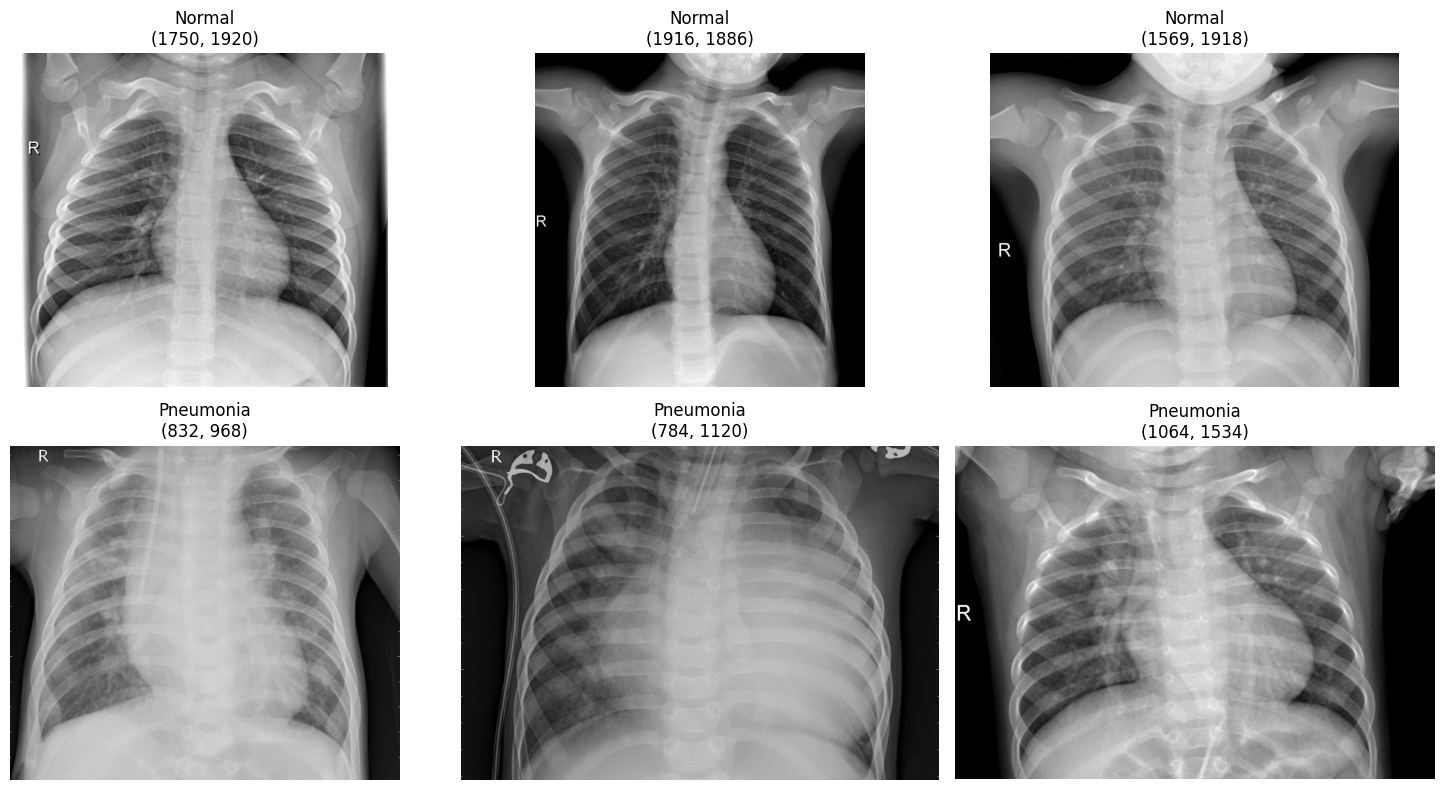

In [14]:
print("\nDisplaying sample images from training set:")
display_samples(data_dir, 'train')

In [15]:
img_height = 512
img_width = 512
batch_size = 32

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # Use 20% of training data for validation
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    color_mode='grayscale'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Training samples: 4695
Validation samples: 521



Displaying augmented training images:


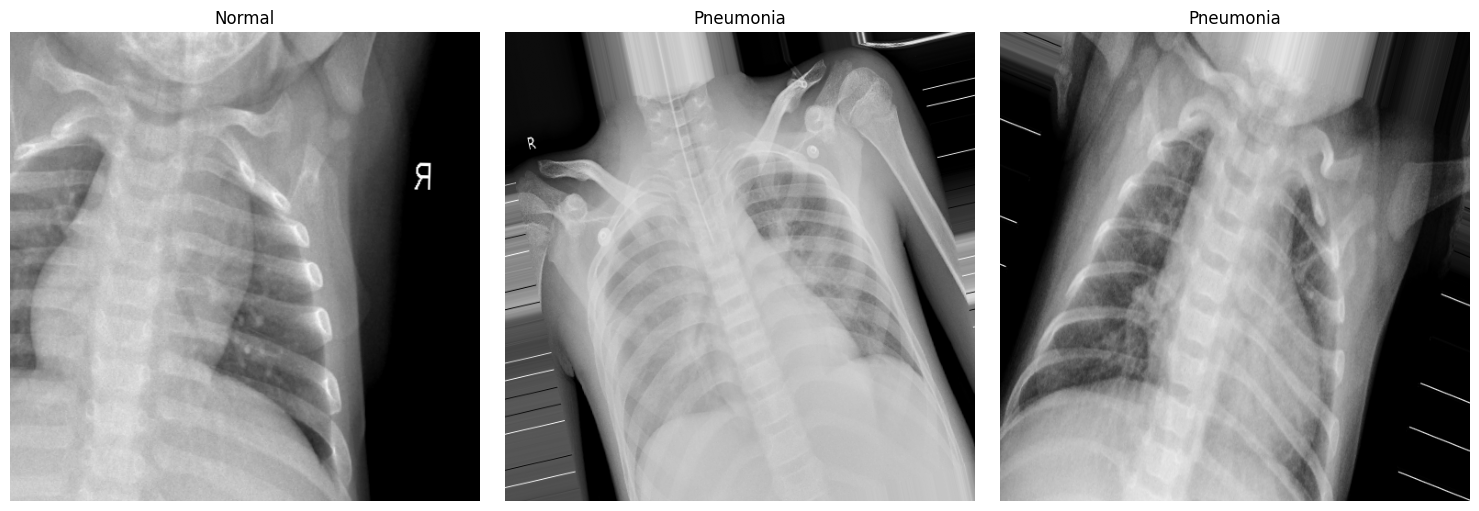

In [17]:
def display_augmented_images(generator, num_images=3):
    # Get a batch from the generator
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(x_batch))):
        plt.subplot(1, num_images, i+1)
        # For grayscale images, we need to squeeze the channel dimension
        plt.imshow(x_batch[i].squeeze(), cmap='gray')
        plt.title('Normal' if y_batch[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nDisplaying augmented training images:")
display_augmented_images(train_generator)

In [18]:
def create_custom_cnn():
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Fifth convolutional block
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

In [19]:
print("\nInitializing custom CNN model...")
model = create_custom_cnn()
print("\nInitialization complete!")


Initializing custom CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Initialization complete!


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [21]:
total_train = train_normal + train_pneumonia
class_weight = {
    0: (1 / train_normal) * (total_train / 2.0),  # Normal
    1: (1 / train_pneumonia) * (total_train / 2.0)  # Pneumonia
}
print("\nClass weights to handle imbalance:", class_weight)


Class weights to handle imbalance: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 255, 255, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 30, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 53,018,497 (202.25 MB)

 Trainable params: 53,016,513 (202.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_pneumonia_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [24]:
print("\nTraining the model...")
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight
)
print("\nTraining Complete!")


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.8159 - auc: 0.8849 - loss: 0.7994 - precision: 0.9192 - recall: 0.8242

146/146 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8161 - auc: 0.8851 - loss: 0.7987 - precision: 0.9193 - recall: 0.8243 - val_accuracy: 0.7422 - val_auc: 0.5000 - val_loss: 5.9331 - val_precision: 0.7422 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
  1/146 ━━━━━━━━━━━━━━━━━━━━ 48s 334ms/step - accuracy: 0.8750 - auc: 0.9182 - loss: 0.4401 - precision: 0.9500 - recall: 0.8636

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.8750 - auc: 0.9182 - loss: 0.4401 - precision: 0.9500 - recall: 0.8636 - val_accuracy: 0.7441 - val_auc: 0.5000 - val_loss: 5.9644 - val_precision: 0.7441 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 187s 949ms/step - accuracy: 0.8903 - auc: 0.9434 - loss: 0.4687 - precision: 0.9570 - recall: 0.8921 - val_accuracy: 0.7402 - val_auc: 0.5000 - val_loss: 7.3267 - val_precision: 0.7402 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/30
  1/146 ━━━━━━━━━━━━━━━━━━━━ 45s 312ms/step - accuracy: 0.8750 - auc: 0.9029 - loss: 0.5181 - precision: 0.9565 - recall: 0.8800

146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 0.8750 - auc: 0.9029 - loss: 0.5181 - precision: 0.9565 - recall: 0.8800 - val_accuracy: 0.7480 - val_auc: 0.5000 - val_loss: 6.7112 - val_precision: 0.7480 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 139s 951ms/step - accuracy: 0.8683 - auc: 0.9298 - loss: 0.5681 - precision: 0.9542 - recall: 0.8648 - val_accuracy: 0.7461 - val_auc: 0.5000 - val_loss: 4.6436 - val_precision: 0.7461 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8438 - auc: 0.9314 - loss: 0.5996 - precision: 0.9545 - recall: 0.8400 - val_accuracy: 0.7383 - val_auc: 0.5000 - val_loss: 5.0488 - val_precision: 0.7383 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 142s 969ms/step - accuracy: 0.8955 - auc: 0.9493 - loss: 0.4418 - precision: 0.9658 - recall: 0.8911 - val_accuracy: 0.7422 - val_auc: 0.5000 - val_loss

146/146 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9128 - auc: 0.9634 - loss: 0.3552 - precision: 0.9744 - recall: 0.9076 - val_accuracy: 0.7637 - val_auc: 0.6677 - val_loss: 2.6838 - val_precision: 0.7585 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 12/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.0573 - precision: 1.0000 - recall: 0.9286 - val_accuracy: 0.7500 - val_auc: 0.5799 - val_loss: 4.6996 - val_precision: 0.7485 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.9020 - auc: 0.9595 - loss: 0.3209 - precision: 0.9698 - recall: 0.8957

146/146 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9020 - auc: 0.9595 - loss: 0.3211 - precision: 0.9698 - recall: 0.8958 - val_accuracy: 0.8574 - val_auc: 0.9443 - val_loss: 0.3326 - val_precision: 0.9842 - val_recall: 0.8211 - learning_rate: 1.0000e-04
Epoch 14/30
  1/146 ━━━━━━━━━━━━━━━━━━━━ 48s 332ms/step - accuracy: 0.8750 - auc: 0.9104 - loss: 1.8041 - precision: 0.9000 - recall: 0.9000

146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - accuracy: 0.8750 - auc: 0.9104 - loss: 1.8041 - precision: 0.9000 - recall: 0.9000 - val_accuracy: 0.8906 - val_auc: 0.9464 - val_loss: 0.2871 - val_precision: 0.9581 - val_recall: 0.8932 - learning_rate: 1.0000e-04
Epoch 15/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9038 - auc: 0.9652 - loss: 0.2884 - precision: 0.9749 - recall: 0.8934 - val_accuracy: 0.7402 - val_auc: 0.5860 - val_loss: 4.4722 - val_precision: 0.7446 - val_recall: 0.9895 - learning_rate: 1.0000e-04
Epoch 16/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8438 - auc: 0.9171 - loss: 0.6232 - precision: 0.9167 - recall: 0.8800 - val_accuracy: 0.7324 - val_auc: 0.5327 - val_loss: 5.9164 - val_precision: 0.7377 - val_recall: 0.9894 - learning_rate: 1.0000e-04
Epoch 17/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9093 - auc: 0.9638 - loss: 0.2876 - precision: 0.9792 - recall: 0.8965 - val_accuracy: 0.7539 - val_auc: 0.9645 - val_loss: 0

146/146 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9133 - auc: 0.9707 - loss: 0.2286 - precision: 0.9738 - recall: 0.9076 - val_accuracy: 0.8945 - val_auc: 0.9670 - val_loss: 0.2172 - val_precision: 0.9822 - val_recall: 0.8734 - learning_rate: 1.0000e-04
Epoch 20/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0789 - precision: 1.0000 - recall: 0.9524 - val_accuracy: 0.8926 - val_auc: 0.9587 - val_loss: 0.2813 - val_precision: 0.9880 - val_recall: 0.8658 - learning_rate: 1.0000e-04
Epoch 21/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 141s 967ms/step - accuracy: 0.9244 - auc: 0.9740 - loss: 0.2057 - precision: 0.9834 - recall: 0.9142 - val_accuracy: 0.7871 - val_auc: 0.7340 - val_loss: 2.6717 - val_precision: 0.7817 - val_recall: 0.9895 - learning_rate: 1.0000e-04
Epoch 22/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8438 - auc: 0.9292 - loss: 0.7381 - precision: 0.8947 - recall: 0.8500 - val_accuracy: 0.7969 - val_auc: 0.7691 - val_loss:


Plotting training history:


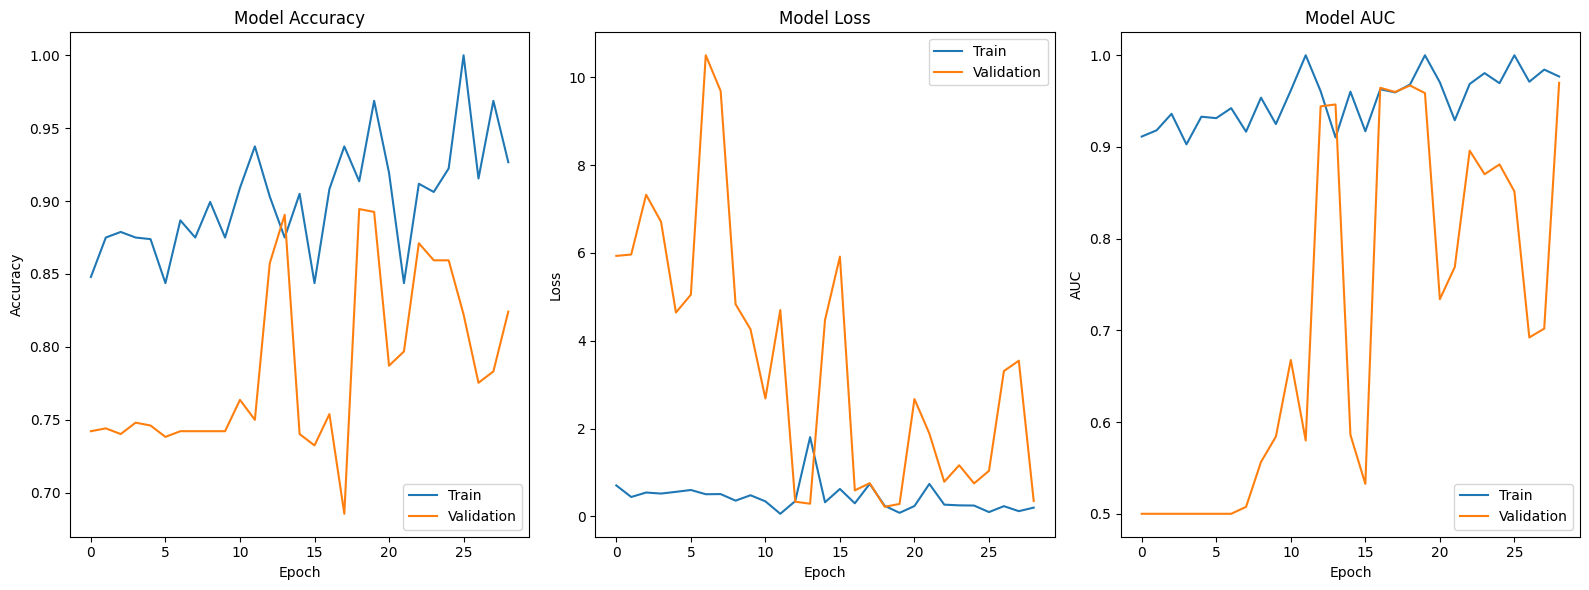

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

print("\nPlotting training history:")
plot_training_history(history)

In [28]:
print("\nEvaluating on test set:")
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)
test_results = model.evaluate(test_generator, steps=max(1, test_generator.samples // batch_size))
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")


Evaluating on test set:
Found 624 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8494 - auc: 0.5983 - loss: 0.3718 - precision: 0.5211 - recall: 0.4711
Test Loss: 0.4143
Test Accuracy: 0.7796
Test AUC: 0.9162
Test Precision: 0.9138
Test Recall: 0.7086


In [31]:
test_generator.reset()
steps = int(np.ceil(test_generator.samples / batch_size))
y_pred = model.predict(test_generator, steps=steps)

y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step



Confusion Matrix:


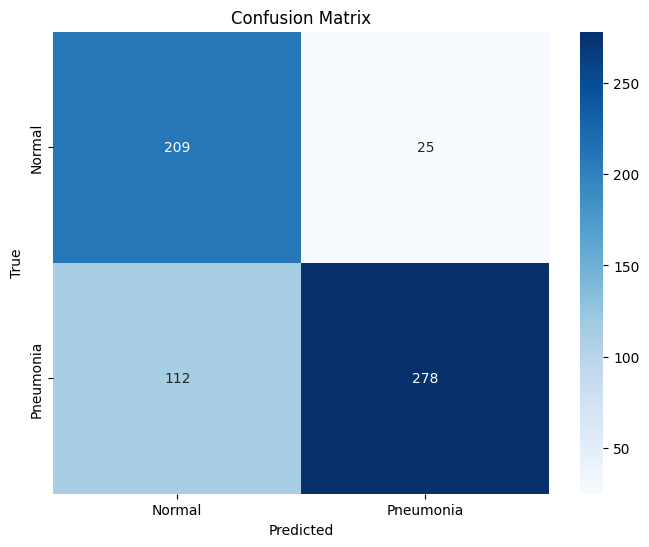

In [32]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                           target_names=['Normal', 'Pneumonia']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      0.89      0.75       234
   Pneumonia       0.92      0.71      0.80       390

    accuracy                           0.78       624
   macro avg       0.78      0.80      0.78       624
weighted avg       0.82      0.78      0.78       624




Visualizing model predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


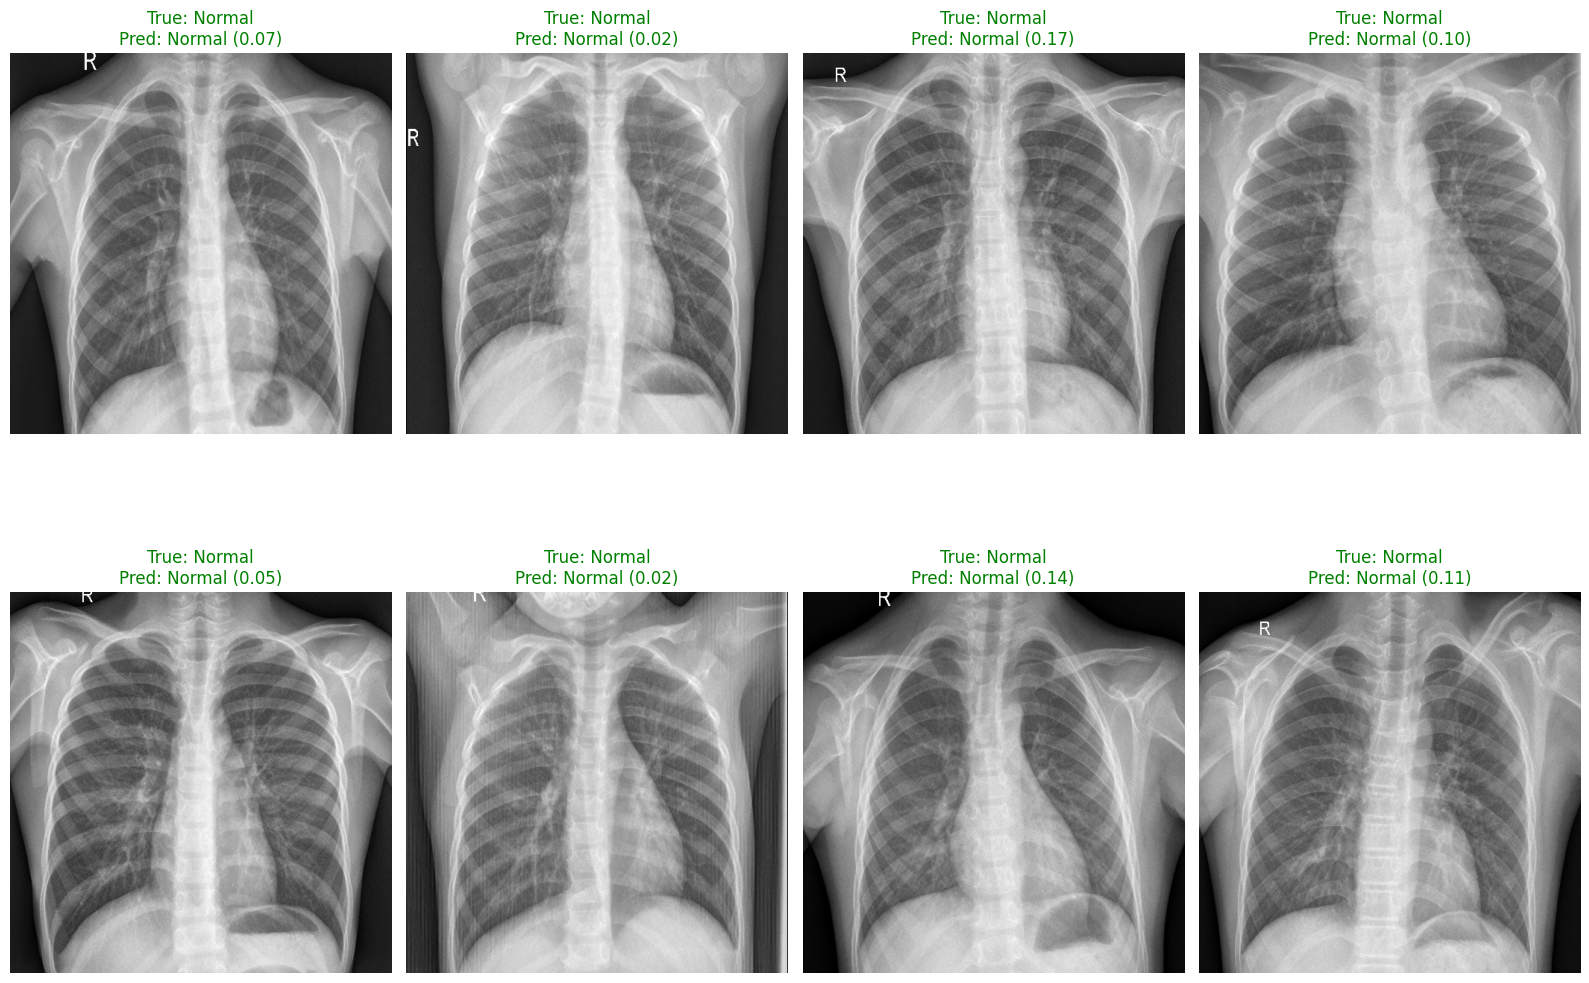

In [34]:
def visualize_predictions(model, test_generator, num_samples=8):
    # Reset generator
    test_generator.reset()

    # Get a batch of images and their true labels
    images, true_labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    pred_labels = (predictions > 0.5).astype(int).flatten()

    # Convert true labels to integers if they're not already
    true_labels = true_labels.astype(int)

    # Display images with predictions
    plt.figure(figsize=(16, 12))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')

        # Get class names
        true_class = 'Normal' if true_labels[i] == 0 else 'Pneumonia'
        pred_class = 'Normal' if pred_labels[i] == 0 else 'Pneumonia'

        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        title = f"True: {true_class}\nPred: {pred_class} ({predictions[i][0]:.2f})"
        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing model predictions:")
visualize_predictions(model, test_generator)

In [35]:
model.save('/content/drive/MyDrive/pneumonia_classifier.h5')
print("\nModel saved to Google Drive as 'pneumonia_classifier.h5'")


Model saved to Google Drive as 'pneumonia_classifier.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


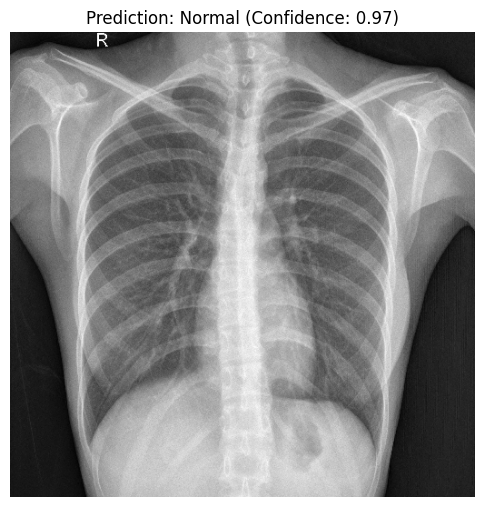

('Normal', np.float32(0.96901137))

In [41]:
def predict_xray(model, image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width), color_mode='grayscale'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = 'Pneumonia' if prediction > 0.5 else 'Normal'
    confidence = prediction[0][0] if prediction > 0.5 else 1 - prediction[0][0]

    plt.figure(figsize=(6, 8))
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

sample_img_path = '/content/pneumonia_data/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
predict_xray(model, sample_img_path)